# Detect and measure sources, estimate PSF and re-measure sources.

This script will perform source detection as follows:

1. Estimate and subtract background 
2. Estimate the PSF:
    2. Create an empty catalog with all the required columns
    2. Repair image, leaves CR's
    2. Detect bright sources
    2. Measure bright sources (fills in the empty catalog)
    2. Estimates the PSF on some of the measured sources that are appropriate
3. Re-measures sources with the estimated PSF

First step is to setup the Spark paths. This only needs to be run once per lifetime of a notebook.

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkConf, SparkContext

conf = SparkConf()
conf.setAppName("Something's happening.")
conf.setMaster("spark://ip-172-31-37-93.us-west-2.compute.internal:7077")
conf.set("spark.executor.memory", '12g')
conf.set('spark.executor.cores', '4')
sc = SparkContext(conf=conf)
sc.addPyFile("/home/ec2-user/lsstspark.zip")

### Ingesting images as ExposureF objects

Images we want processed need to be ingested as a Spark RDD. To do this we register all images we want processed. In this case this is done by explicitly stating the path to the file we want processed as a string and then ingesting that path into an RDD. This ingestion of data can be replaced by whatever data structure desired. For example, selecting paths, or links, to exposures from an SQL database based on additional metadata from the table.

To be able to process these exposures we need to map them to `lsst.afw.image.ExposureF` objects. This can be whatever user-deined function is required. For example, if the ingested paths are a mix of filesystem paths and links this function would deal with conditions and then download the images (or not) and open them as `ExposureF` objects. In this case, only 1 image is being processed and the mapping is trivial because it conforms to the instantiation signature of `ExposureF` class.

In [2]:
import lsst.afw.image
import lsstspark as ls

def toExposureF(exposurePath):
    return lsst.afw.image.ExposureF(exposurePath)

calexppath = "s3://dinolsstspark/sci_exposures/calexp-0308355_01.fits"
expPathsRDD = sc.parallelize([calexppath])
expRDD = expPathsRDD.map(ls.utils.toExposureF)

### Source Detection

To detect and measure sources (without astrometry or photometry yet) `detect_and_measure` function is mapped to the RDD containing exposures. To set up detection parameters `detect_and_measure` is written as a wrapper to a function that does the detection and measurament steps. The signature of this function listing availible parameters is shown below.

In [3]:
from lsstspark.detectSources import detect_and_measure
help(detect_and_measure)

Help on function detect_and_measure in module lsstspark.detectSources:

detect_and_measure(psfIterations=2, doMeasurePsf=True)
    A wrapper that returns a function that can be mapped to RDDs. 
    
    Parameters
    ----------
    psfIterations : number of times PSF is estimated on the exposure.
    doMeasurePsf  : boolean value, if set to False PSF will be estimated 
                    1 time. ****TO DO:****
                                      implement installing of a default Gaussian
                                      PSF
    Returns
    ----------
    Function that estimates background, PSF, repairs exposure defects, repairs CRs, 
    detects and measures sources on a given exposure.



Parameters are set up the returned function can be mapped to an RDD of exposures. The signature of the function that does the processing, named `sourceDetection`, is shown below.

In [4]:
sourceDetection = detect_and_measure(psfIterations=2, doMeasurePsf=True)
detMeasRDD = expRDD.map(sourceDetection)
help(sourceDetection)

Help on function det_meas in module lsstspark.detectSources:

det_meas(exposure)
    Estimate background and PSF, repair exposure defects and CRs, detect and
       measure sources. 
    
    Parameters
    ----------
    exposurePath : path to an exposure of the sky (lsst.afw.ExposureF object)
    
    Returns
    ----------
    exposure : exposure of the sky given by exposurePath (lsst.afw.ExposureF)
    calexp   : exposure of the sky with subtracted background, repaired defects
               and CRs (lsst.afw.ExposureF)
    sources  : catalog of detected sources on the calexp
               (lsst.afw.table.SourceCatalog)
    backg    : estimated background of exposure, a list-like object containing 
               tuples of (afwMath.Background, interpStyle, undersampleStyle)



### Inspecting the results

Since we are only working with 1 test image we can take only the first result and inspect the elements of the returned list. Equivalent to calling `.first()`.

In [5]:
sciexp, calexp, srcs, bckgs  = detMeasRDD.take(1)[0]

For example we can plot the in-going image, its estimated background and the resulting image (from left to right). The resulting image should be different than the ingoing image, since the background is subtracted and defects (including CRs) are interpolated over, but is not in this case because the ingoing image is already of `calexp` datatype. `Calexp` images have already gone through this procedure once and therefore have their backgrounds subtracted and defects resolved.             

On the resulting image we also overplot all detected sources and color those sources that were used in PSF estimation in orange.

/home/ec2-user/anaconda3/envs/lsststack/lib/python3.6/site-packages/astropy/visualization/stretch.py:368: RuntimeWarning: overflow encountered in sinh
  np.sinh(values, out=values)


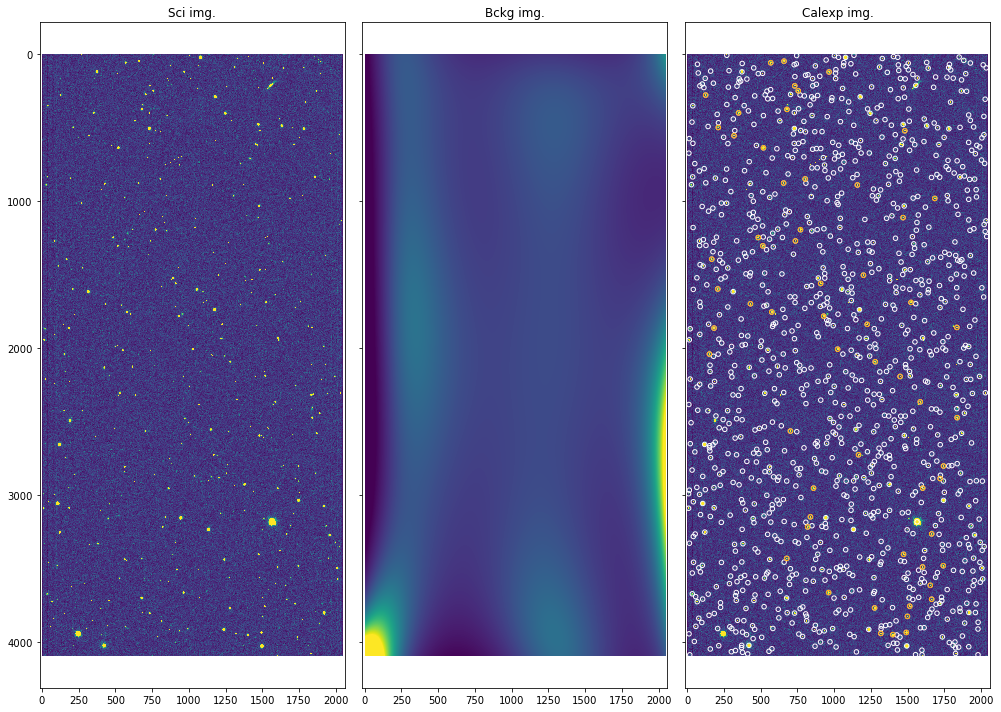

In [6]:
%matplotlib inline
import astropy.visualization as visz
import matplotlib.pyplot as plt

def imgnorm(img):
    minv, maxv = visz.ZScaleInterval().get_limits(img)
    norm = visz.ImageNormalize(vmin=minv, vmax=maxv, stretch=visz.SinhStretch())
    return norm

sciimg = sciexp.getImage()
calimg = calexp.getImage()
bcgimg = bckgs.background.getImage()
#bckgimg = exposure.getImage()

norm1 = imgnorm(sciimg.array)
norm2 = imgnorm(bcgimg.array)
norm3 = imgnorm(calimg.array)

fig, axes = plt.subplots(1, 3, figsize=(14, 10), sharey=True)

axes[0].imshow(sciimg.array, norm=norm1)
axes[1].imshow(bcgimg.array, norm=norm2)
axes[2].imshow(calimg.array, norm=norm3)

for src in srcs:
    axes[2].scatter(src.getX(), src.getY(), marker="o",  s=20, edgecolor="white", facecolor="None")
    
for src in srcs[srcs["calib_psfUsed"]]:
    axes[2].scatter(src.getX(), src.getY(), marker="o",  s=20, edgecolor="orange", facecolor="None")

axes[0].set_title("Sci img.")
axes[1].set_title("Bckg img.")
axes[2].set_title("Calexp img.")

#[ax.grid(False) for ax in axes]
plt.tight_layout()
plt.show()

In addition to graphical representation of the results the detected sources can be returned as an Astropy `Table` objects.

In [7]:
srcs.asAstropy()

id,coord_ra,coord_dec,parent,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xSigma,slot_Centroid_xSigma,base_SdssCentroid_ySigma,slot_Centroid_ySigma,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_Blendedness_old,base_Blendedness_raw_flux,base_Blendedness_raw_flux_child,base_Blendedness_raw_flux_parent,base_Blendedness_abs_flux,base_Blendedness_abs_flux_child,base_Blendedness_abs_flux_parent,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_xx,base_Blendedness_abs_parent_yy,base_Blendedness_abs_parent_xy,base_Blendedness_flag,base_Blendedness_flag_noCentroid,base_Blendedness_flag_noShape,base_SdssShape_xx,slot_Shape_xx,base_SdssShape_yy,slot_Shape_yy,base_SdssShape_xy,slot_Shape_xy,base_SdssShape_xxSigma,slot_Shape_xxSigma,base_SdssShape_yySigma,slot_Shape_yySigma,base_SdssShape_xySigma,slot_Shape_xySigma,base_SdssShape_x,slot_Shape_x,base_SdssShape_y,slot_Shape_y,base_SdssShape_flux,slot_Shape_flux,base_SdssShape_fluxSigma,slot_Shape_fluxSigma,base_SdssShape_psf_xx,slot_PsfShape_xx,slot_Shape_psf_xx,base_SdssShape_psf_yy,slot_PsfShape_yy,slot_Shape_psf_yy,base_SdssShape_psf_xy,slot_PsfShape_xy,slot_Shape_psf_xy,base_SdssShape_flux_xx_C